# Result

Here are presented the first results of the analyse of Wikipedia RFA. For more detail about our work, method, timeline and objective, see the readme on the github reprository here: https://github.com/epfl-ada/ada-2024-project-supercoolteamname2024/tree/main

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import os
import csv


# Read the data from classifications.txt file
file_path = os.path.join('data', 'user_categories_clean.csv')

# Parse the file with careful handling for embedded commas and quotes
rows = []
with open(file_path, 'r') as file:
    reader = csv.reader(file, delimiter=',', quotechar='"', skipinitialspace=True)
    for line in reader:
        rows.append(line)

# Create a DataFrame from parsed data
df = pd.DataFrame(rows[1:], columns=rows[0])  # Use the first row as the header

# Fix incorrect splits for usernames or categories
# Combine values if a row has more columns than expected (e.g., 5)
fixed_rows = []
expected_columns = len(rows[0])  # Expecting 5 columns (username + 4 categories)
for row in rows[1:]:
    if len(row) > expected_columns:
        fixed_row = row[:expected_columns - 1] + [','.join(row[expected_columns - 1:])]
        fixed_rows.append(fixed_row)
    elif len(row) == expected_columns:
        fixed_rows.append(row)

# Create a DataFrame from fixed rows
df = pd.DataFrame(fixed_rows, columns=rows[0])

# Replace non-matching categories with NaN
categories = [
    "Arts", "Academic disciplines", "Business", "Biology", "Communication", "Concepts", "Culture", "Economy", "Education", "Energy",
    "Engineering", "Environment", "Entertainment", "Entities", "Food and drink", "Geography", "Government", "Health", "History",
    "Human behavior", "Humanities", "Information", "Internet", "Knowledge", "Language", "Law", "Life", "Lists", "Literature",
    "Mass media", "Media", "Mathematics", "Military", "Music", "Nature", "People", "Philosophy", "Politics", "Religion", "Science", 
    "Society", "Sports", "Technology", "Time", "Transportation", "Television", "Universe"
]


# Display the updated DataFrame
display(df.head())
for col in df.columns[1:]:  # Exclude the first column (username)
    df[col] = df[col].apply(lambda x: x if x in categories else np.nan)

# Count the total number of NaN values in the DataFrame
total_nans = df.isna().sum().sum()

# Print the result
print(f"Total number of NaN values: {total_nans}")

# Count NaN values per column
nans_per_column = df.isna().sum()

# Print the per-column breakdown
print("\nNaN values per column:")
print(nans_per_column)


,username,categ1,categ2,categ3,categ4
0,!---slappdash---!,Entertainment,Music,Sports,Culture
1,%D0%90,Mass media,Lists,Geography,Education
2,'sed',Television,Cartoons,Culture,Humor
3,(.Y.),Music,Lists,Technology,Entertainment
4,(Julien:):,Sports,Politics,Society,History


Total number of NaN values: 4041

NaN values per column:
username       0
categ1       492
categ2       841
categ3      1176
categ4      1532
dtype: int64


# Categories distribution

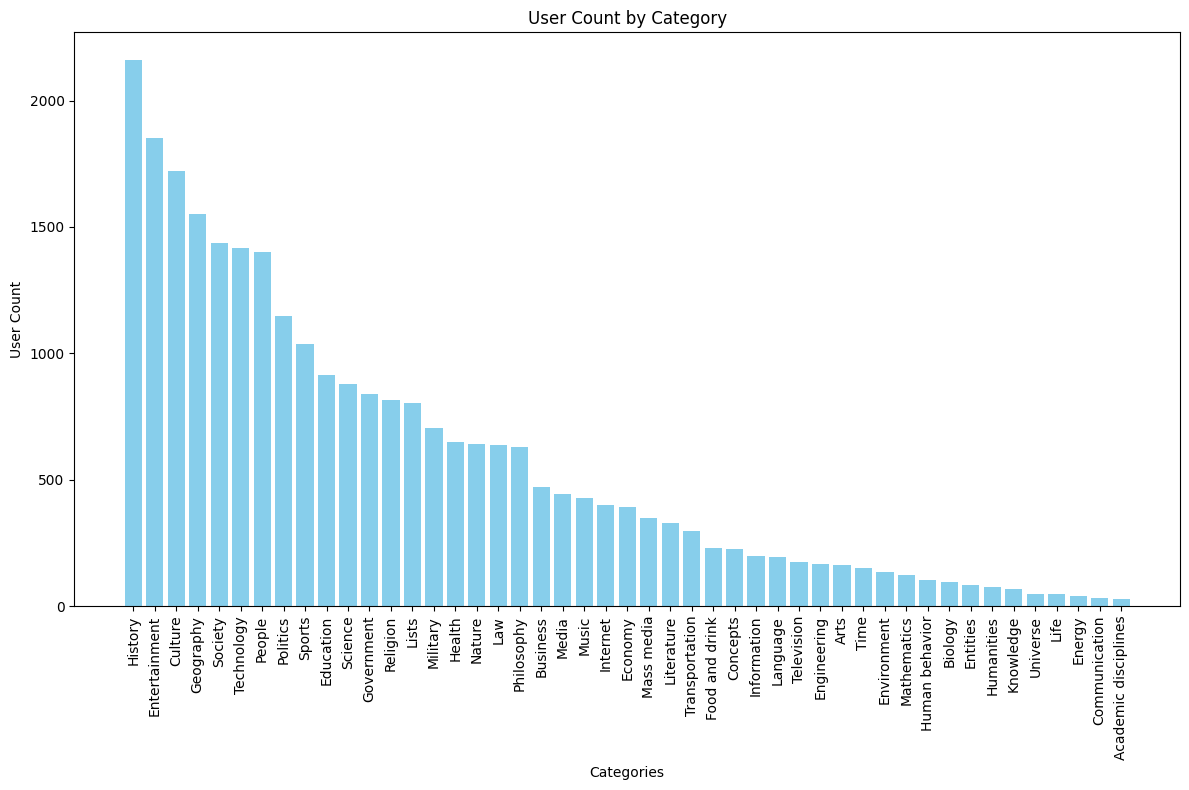

In [61]:
# Flatten all category columns and count occurrences of categories
flattened_categories = df.iloc[:, 1:].fillna('').values.flatten()
category_counts = pd.Series(flattened_categories).value_counts()

# Create a DataFrame for counts
topic_counts_df = category_counts.reset_index()
topic_counts_df.columns = ['Topic', 'Count']
topic_counts_df = topic_counts_df[topic_counts_df['Topic'].isin(categories)]  # Filter for valid categories

# Plotting the topics with their counts in the order provided
plt.figure(figsize=(12, 8))
plt.bar(topic_counts_df["Topic"], topic_counts_df["Count"], color="skyblue")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel("Categories")
plt.ylabel("User Count")
plt.title("User Count by Category")
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()



The bar chart illustrates a diverse distribution of user interests across various categories, with each user potentially belonging to up to 4 different categories. The varying sizes of these categories may be attributed to the breadth of the topics themselves, as some categories, like Technology, may encompass broader subtopics such as Internet. Notably, certain categories have significantly higher user counts, while others are relatively small. To ensure statistical significance in subsequent analyses, we plan to exclude the smallest categories where the sample size may be insufficient for robust conclusions

# Participation rate same/different group

In [66]:
# Initialize the data dictionary to store parsed records
data = {
    "SRC": [],
    "TGT": [],
    "VOT": [],
    "Category_Same": [],
    "SRC_Category": [],
    "TGT_Category": [],
}

# Parse the wiki-RfA.txt file
with open('data/wiki-RfA.txt', 'r', encoding='utf-8') as file:
    record = {}
    for line in file:
        line = line.strip()
        
        # Check if line is empty (end of a record)
        if not line:
            # Save the current record if it has data and reset
            if record:
                src_cat = set(category_mapping.get(record.get("SRC", ""), []))
                tgt_cat = set(category_mapping.get(record.get("TGT", ""), []))
                
                # Skip if either source or target has no categories assigned
                if not src_cat or not tgt_cat:
                    record = {}
                    continue
                
                # Determine if categories match
                record["Category_Same"] = int(bool(src_cat & tgt_cat))  # 1 if any category matches, else 0
                record["SRC_Category"] = list(src_cat & set(top_20_categories))  # Intersection with top categories
                record["TGT_Category"] = list(tgt_cat & set(top_20_categories))  # Intersection with target categories
                
                # Append record to data dictionary
                data["SRC"].append(record.get("SRC", ""))
                data["TGT"].append(record.get("TGT", ""))
                data["VOT"].append(int(record.get("VOT", 0)))
                data["Category_Same"].append(record["Category_Same"])
                data["SRC_Category"].append(record["SRC_Category"][0] if record["SRC_Category"] else None)
                data["TGT_Category"].append(record["TGT_Category"][0] if record["TGT_Category"] else None)
                record = {}
            continue
        
        # Match each line with its prefix and store it in the record dictionary
        match = re.match(r"^(SRC|TGT|VOT):(.*)$", line)
        if match:
            key, value = match.groups()
            record[key] = value.strip()
            
# Convert data dictionary to a DataFrame
df_vote = pd.DataFrame(data)


Top 15 Categories by User Count: ['Politics', 'Science', 'Entertainment', 'Geography', 'History', 'Sports', 'Lists', 'Religion', 'Education', 'Society', 'Technology', 'Law', 'Philosophy', 'Culture', 'Business']


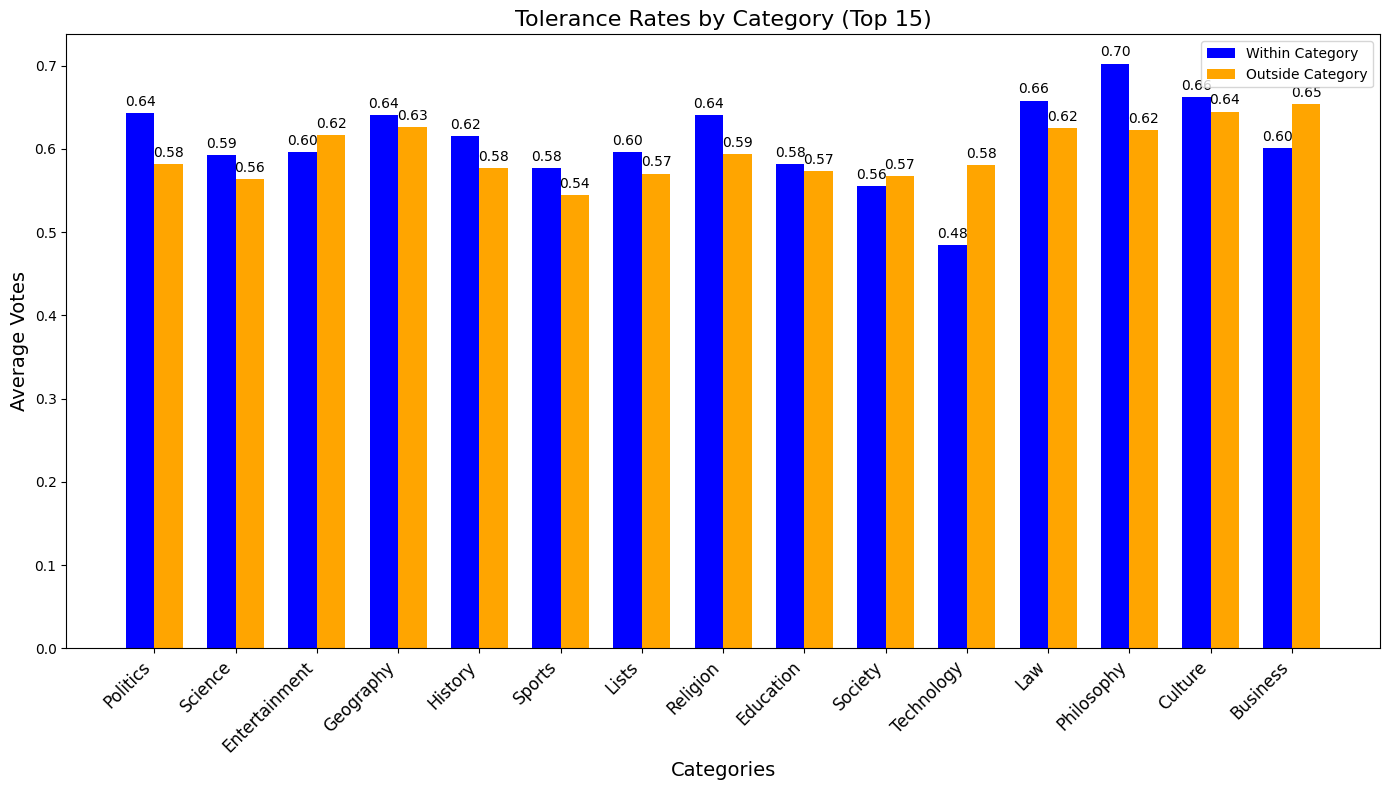

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Combine and count all categories across SRC_Category and TGT_Category
flattened_categories = pd.concat([df_vote['SRC_Category'], df_vote['TGT_Category']]).dropna()
category_counts = flattened_categories.value_counts()

# Select the top 15 categories by user count
top_15_categories = category_counts.head(15).index.tolist()
print(f"Top 15 Categories by User Count: {top_15_categories}")

# Calculate tolerance rates for the top 15 categories
tolerance_data = []
for category in top_15_categories:
    # Determine votes within and outside the category
    within_votes = df_vote[(df_vote['SRC_Category'] == category) & (df_vote['Category_Same'] == 1)]['VOT'].mean()
    outside_votes = df_vote[(df_vote['SRC_Category'] == category) & (df_vote['Category_Same'] == 0)]['VOT'].mean()
    tolerance_data.append((category, within_votes, outside_votes))

# Convert to structured format for plotting
categories, within_category_votes, outside_category_votes = zip(*tolerance_data)

# Plotting
x = np.arange(len(categories))  # the label locations
bar_width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - bar_width / 2, within_category_votes, bar_width, label='Within Category', color='blue')
rects2 = ax.bar(x + bar_width / 2, outside_category_votes, bar_width, label='Outside Category', color='orange')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Average Votes', fontsize=14)
ax.set_title('Tolerance Rates by Category (Top 15)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=12)
ax.legend()

# Annotate bars with values
for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

for rect in rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

fig.tight_layout()
plt.show()


Analyzing the top 10 largest categories, we observe that users are more inclined to participate in votes related to topics that align with their own interests. This can be explained by the fact that individuals are likely to feel more knowledgeable or proficient in certain areas, making them more comfortable expressing their opinions or casting votes. This trend persists, even in the mid-sized categories ranked 10 to 20, suggesting a consistent preference for engaging with familiar topics across the user base.


# Tolerance across same/different categories

## Code


In [ ]:
import re
import pandas as pd
from collections import Counter
from scipy.stats import chi2_contingency
from IPython.display import display  # For rendering in Jupyter Notebook
from IPython.display import HTML


#  Parse classifications.txt to create a category mapping for each user
category_mapping = {}
with open('data/classifications.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("Here are the classifications"):  # Skip empty or irrelevant lines
            continue
        
        # Extract the username and categories
        match = re.match(r'^(.+?):\s(.*)$', line)  # Fixed regex to correctly capture username and categories
        if match:
            user, categories_str = match.groups()
            categories = [cat.strip() for cat in categories_str.split(",") if cat.strip()]  # Avoid empty categories
            category_mapping[user.strip()] = categories

# Flatten the category list to count occurrences and get the top 20 categories
all_categories = [cat for categories in category_mapping.values() for cat in categories]
top_20_categories = [cat for cat, _ in Counter(all_categories).most_common(20)]


#  Parse wiki-RfA.txt to extract votes and determine "Same Category" or "Different Category"
data = {
    "SRC": [],
    "TGT": [],
    "VOT": [],
    "Category_Same": [],  # New column to track if category matches
    "SRC_Category": [],  # Store source category
    "TGT_Category": []   # Store target category (added for clarity)
}

with open('data/wiki-RfA.txt', 'r', encoding='utf-8') as file:
    record = {}
    for line in file:
        line = line.strip()
        
        # Check if line is empty (end of a record)
        if not line:
            # Save the current record if it has data and reset
            if record:
                src_cat = set(category_mapping.get(record.get("SRC", ""), []))
                tgt_cat = set(category_mapping.get(record.get("TGT", ""), []))
                
                # Skip if either source or target has no categories assigned
                if not src_cat or not tgt_cat:
                    record = {}
                    continue
                
                # Determine if categories match
                record["Category_Same"] = int(bool(src_cat & tgt_cat))  # 1 if any category matches, else 0
                record["SRC_Category"] = list(src_cat & set(top_20_categories))  # Intersection with top categories
                record["TGT_Category"] = list(tgt_cat & set(top_20_categories))  # Intersection with target categories
                
                # Append record to data dictionary
                data["SRC"].append(record.get("SRC", ""))
                data["TGT"].append(record.get("TGT", ""))
                data["VOT"].append(int(record.get("VOT", 0)))
                data["Category_Same"].append(record["Category_Same"])
                data["SRC_Category"].append(record["SRC_Category"][0] if record["SRC_Category"] else None)
                data["TGT_Category"].append(record["TGT_Category"][0] if record["TGT_Category"] else None)
                record = {}
            continue
        
        # Match each line with its prefix and store it in the record dictionary
        match = re.match(r"^(SRC|TGT|VOT):(.*)$", line)
        if match:
            key, value = match.groups()
            record[key] = value.strip()

    # Add the last record if any data is left
    if record:
        src_cat = set(category_mapping.get(record.get("SRC", ""), []))
        tgt_cat = set(category_mapping.get(record.get("TGT", ""), []))
        
        # Skip if either source or target has no categories assigned
        if not src_cat or not tgt_cat:
            record = {}
        else:
            record["Category_Same"] = int(bool(src_cat & tgt_cat))
            record["SRC_Category"] = list(src_cat & set(top_20_categories))
            record["TGT_Category"] = list(tgt_cat & set(top_20_categories))

            data["SRC"].append(record.get("SRC", ""))
            data["TGT"].append(record.get("TGT", ""))
            data["VOT"].append(int(record.get("VOT", 0)))
            data["Category_Same"].append(record["Category_Same"])
            data["SRC_Category"].append(record["SRC_Category"][0] if record["SRC_Category"] else None)
            data["TGT_Category"].append(record["TGT_Category"][0] if record["TGT_Category"] else None)

# Convert data into a DataFrame
df = pd.DataFrame(data)



# Analyze tolerance rates for each of the 20 biggest categories
results = []
for category in top_20_categories:
    # Filter votes by users in the current category
    category_votes = df[df['SRC_Category'] == category]
    
    # Calculate positive and negative vote counts within and outside the category
    same_category_votes = category_votes[category_votes['Category_Same'] == 1]
    diff_category_votes = category_votes[category_votes['Category_Same'] == 0]
    
    same_pos_count = (same_category_votes['VOT'] == 1).sum()
    same_neg_count = (same_category_votes['VOT'] == -1).sum()
    diff_pos_count = (diff_category_votes['VOT'] == 1).sum()
    diff_neg_count = (diff_category_votes['VOT'] == -1).sum()
    
    # Check if we have non-zero counts before performing the Chi-square test
    if same_pos_count > 0 and same_neg_count > 0 and diff_pos_count > 0 and diff_neg_count > 0:
        contingency_table = [[same_pos_count, same_neg_count], [diff_pos_count, diff_neg_count]]
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
    else:
        chi2, p_value = None, None  # If any count is zero, skip the Chi-square test
    
    # Append results for this category
    results.append({
        "Category": category,
        "Same_Pos": same_pos_count,
        "Same_Neg": same_neg_count,
        "Diff_Pos": diff_pos_count,
        "Diff_Neg": diff_neg_count,
        "Chi-Square Distance": chi2 if chi2 is not None else "N/A",
        "p-value": p_value if p_value is not None else "N/A"
    })

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results)

# Convert the results DataFrame into a nicely formatted HTML table
results_html = results_df.to_html(index=False, columns=["Category", "Same_Pos", "Same_Neg",  "Diff_Pos", "Diff_Neg", "Chi-Square Distance", "p-value"], justify="center", border=1)

# Select and rename columns for clarity
results_table = results_df[["Category", "Same_Pos", "Same_Neg", "Diff_Pos", "Diff_Neg", "p-value"]]
results_table.columns = ["Category", "Same Category Positive Votes", "Same Category Negative Votes", "Different Category Positive Votes", "Different Category Negative Votes", "p-value"]

# Display the table as a styled HTML table
styled_table = results_table.style.set_table_styles(
    [
        {'selector': 'th', 'props': [('background-color', '#f7f7f7'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
    ]
).set_caption("Tolerance Analysis Results")




In [ ]:
from IPython.display import display

# Select three categories to analyze
categories_to_analyze = ["Entertainment", "Geography", "Business"]

# Filter the results_table for the selected categories
selected_categories = results_table[results_table["Category"].isin(categories_to_analyze)]

# Compute rates and prepare analysis
rate_analysis = []

for _, row in selected_categories.iterrows():
    category = row["Category"]
    same_pos = row["Same Category Positive Votes"]
    diff_pos = row["Different Category Positive Votes"]
    same_neg = row["Same Category Negative Votes"]
    diff_neg = row["Different Category Negative Votes"]
    
    # Calculate totals
    total_same = same_pos + same_neg
    total_diff = diff_pos + diff_neg
    
    # Calculate rates
    same_pos_rate = same_pos / total_same if total_same > 0 else 0
    diff_pos_rate = diff_pos / total_diff if total_diff > 0 else 0
    
    # Append to analysis
    rate_analysis.append({
        "Category": category,
        "Positive Rate Within Same (%)": same_pos_rate * 100,
        "Positive Rate Within Different (%)": diff_pos_rate * 100
    })

# Convert to DataFrame for display
selected_rates_df = pd.DataFrame(rate_analysis)



## Table
 We tried to test the null hypothesis that tolerance rate is the same whether they are in the same/different category, p-values are on the last collumn.

In [ ]:
# Render the styled table
display(styled_table)

,Category,Same Category Positive Votes,Same Category Negative Votes,Different Category Positive Votes,Different Category Negative Votes,p-value
0,Entertainment,939,273,1477,330,0.004727
1,Culture,6387,1244,6413,1371,0.031787
2,History,1378,347,1338,378,0.182412
3,Technology,4233,944,5145,1085,0.265317
4,Geography,274,96,489,117,0.018456
5,Politics,696,140,970,194,1.000000
6,Education,986,195,1170,228,0.932305
7,People,1962,363,2301,484,0.098395
8,Society,54,10,147,18,0.451576
9,Science,374,87,845,284,0.008733


In [ ]:
# Display computed rates
print("Computed Rates for Selected Categories:")
display(selected_rates_df.style.set_caption("Positive Rate Analysis for Selected Categories"))

# Brief analysis
print("\nAnalysis:")
print("We can see that the rate of positiv vote is greater when the target of the vote is from a \ndifferent group,  hence we could think that they are stricter and more exigent with people \nfrom their category.")
print("Among certain group, p-values indicate significantly different level of tolerance whether \nthey belong to the same group or not is. ")

Computed Rates for Selected Categories:


,Category,Positive Rate Within Same (%),Positive Rate Within Different (%)
0,Entertainment,77.475248,81.737687
1,Geography,74.054054,80.693069
2,Business,80.524079,83.140054



Analysis:
We can see that the rate of positiv vote is greater when the target of the vote is from a 
different group,  hence we could think that they are stricter and more exigent with people 
from their category.
Among certain group, p-values indicate significantly different level of tolerance whether 
they belong to the same group or not is. 


# Code

In [ ]:
import re
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Load `wiki-RfA.txt` to extract votes, dates, and categories
data = {
    "SRC": [],
    "TGT": [],
    "VOT": [],
    "DAT": []  # Temporarily keep 'DAT' as text for debugging
}

with open('data/wiki-RfA.txt', 'r', encoding='utf-8') as file:
    record = {}
    for line in file:
        line = line.strip()
        
        # Check if line is empty (end of a record)
        if not line:
            if record:
                # Add data to dictionary, with 'DAT' as-is for now
                data["SRC"].append(record.get("SRC", ""))
                data["TGT"].append(record.get("TGT", ""))
                data["VOT"].append(int(record.get("VOT", 0)))
                data["DAT"].append(record.get("DAT", ""))  # Keep 'DAT' as raw text for inspection
                record = {}
            continue
        
        # Match each line by prefix
        match = re.match(r"^(SRC|TGT|VOT|DAT):(.*)$", line)
        if match:
            key, value = match.groups()
            record[key] = value.strip()

# Convert data into a DataFrame
df = pd.DataFrame(data)
print(f"Total unique voters in data: {df['SRC'].nunique()}")

# Proceed with date parsing if 'DAT' appears consistent
df['Date'] = pd.to_datetime(df['DAT'], errors='coerce', format='%H:%M, %d %B %Y')
df.dropna(subset=['Date'], inplace=True)  # Remove any rows with invalid dates
df['Year'] = df['Date'].dt.year


# Calculate positivity ratio per voter per year
# Positivity ratio: positive votes / total votes per user per year
voter_yearly_tolerance = df.groupby(['SRC', 'Year'])['VOT'].apply(
    lambda x: (x == 1).sum() / len(x) if len(x) > 0 else 0
).reset_index(name='Positivity_Ratio')

single_year_voters = voter_yearly_tolerance.groupby('SRC').filter(lambda x: len(x) == 1)['SRC'].nunique()
print(f"Voters with data for only one year: {single_year_voters}")

# Analyze trend for each voter using linear regression
voter_trends = []
for voter in voter_yearly_tolerance['SRC'].unique():
    voter_data = voter_yearly_tolerance[voter_yearly_tolerance['SRC'] == voter]
    if len(voter_data) > 1:  # Ensure multiple years of data for trend analysis
        slope, _, _, p_value, _ = linregress(voter_data['Year'], voter_data['Positivity_Ratio'])
        trend = 'Constant'
        if slope > 0 and p_value < 0.05:
            trend = 'More Lenient'
        elif slope < 0 and p_value < 0.05:
            trend = 'More Strict'
        voter_trends.append({
            'Voter': voter,
            'Trend': trend,
            'Slope': slope,
            'p_value': p_value
        })

# Convert to DataFrame for analysis
voter_trends_df = pd.DataFrame(voter_trends)



Total unique voters in data: 10417
Voters with data for only one year: 5984


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency
from collections import Counter

# Ensure categories are mapped correctly in voter_trends_df
voter_trends_df['Categories'] = voter_trends_df['Voter'].map(category_mapping).apply(lambda x: x if isinstance(x, list) else [])

# Calculate the overall trend distribution
overall_trend_counts = voter_trends_df['Trend'].value_counts()
total_voters = overall_trend_counts.sum()
overall_trend_distribution = (overall_trend_counts / total_voters).to_dict()

#  Identify top 20 most populated categories
category_counts = Counter()
for categories_list in voter_trends_df['Categories']:
    if categories_list:
        for category in categories_list:
            category_counts[category] += 1

top_20_categories = [category for category, _ in category_counts.most_common(20)]

#  Calculate trend distribution for each of the top 20 categories and create table data
table_data = []
for category in top_20_categories:
    # Count the number of voters with each trend in the current category
    trend_counts = {'More Lenient': 0, 'More Strict': 0, 'Constant': 0}
    for _, row in voter_trends_df.iterrows():
        if row['Categories'] and category in row['Categories']:
            trend_counts[row['Trend']] += 1
    
    # Calculate percentages for each trend
    category_total = sum(trend_counts.values())
    more_lenient_pct = (trend_counts['More Lenient'] / category_total) * 100 if category_total > 0 else 0
    more_strict_pct = (trend_counts['More Strict'] / category_total) * 100 if category_total > 0 else 0
    constant_pct = (trend_counts['Constant'] / category_total) * 100 if category_total > 0 else 0

    # Create observed and expected arrays for chi-square test
    observed = [trend_counts['More Lenient'], trend_counts['More Strict'], trend_counts['Constant']]
    expected = [overall_trend_distribution[trend] * category_total for trend in ['More Lenient', 'More Strict', 'Constant']]
    
    # Calculate chi-square distance and p-value
    chi2, p_value = chi2_contingency([observed, expected])[:2]
    
    # Append row to table data
    table_data.append({
        'Category': category,
        'More Lenient (%)': f"{more_lenient_pct:.2f}",
        'More Strict (%)': f"{more_strict_pct:.2f}",
        'Constant (%)': f"{constant_pct:.2f}",
        'Chi-square Distance': f"{chi2:.4f}",
        'p-value': f"{p_value:.4f}"
    })

# Convert to DataFrame for display
table_df = pd.DataFrame(table_data)

# Display the table sorted by Chi-square distance
table_df = table_df.sort_values(by='Chi-square Distance', ascending=False)


# Calculate the overall trend distribution in percentages
overall_trend_distribution_pct = {
    trend: (count / total_voters) * 100 for trend, count in overall_trend_counts.items()
}

# Display the overall trend distribution
overall_distribution = {
    'Category': 'Overall',
    'More Lenient (%)': f"{overall_trend_distribution_pct['More Lenient']:.2f}",
    'More Strict (%)': f"{overall_trend_distribution_pct['More Strict']:.2f}",
    'Constant (%)': f"{overall_trend_distribution_pct['Constant']:.2f}",
    'Chi-square Distance': 'N/A',  # No Chi-square comparison for overall
    'p-value': 'N/A'
}

# Append the overall distribution to the table for comparison
table_df = pd.concat([pd.DataFrame([overall_distribution]), table_df], ignore_index=True)



# Votants Behavior 

We are studying behavior of votants, trying to see if they became more or less strict over the years, for that we look at voters that have voted in more than 1 year.

In [ ]:
if not voter_trends_df.empty:
    print("Summary of Voter Tolerance Trends Over Time:")
    print(voter_trends_df["Trend"].value_counts())
else:
    print(
        "No data available in voter_trends_df. Ensure there are multiple years of data per voter."
    )

Summary of Voter Tolerance Trends Over Time:
Trend
Constant        2377
More Strict      786
More Lenient     680
Name: count, dtype: int64


## Difference of behavior in the differents groups?

To test this we run the test with the null hypothesis is that the distribution of people being more strict/less strict and constant is the same among the groups than among the overall, the p-values are stored in the last collumn.

In [ ]:

# Display the table
display(table_df.style.set_caption("Trend Distribution by Category with Chi-square Comparison:"))


,Category,More Lenient (%),More Strict (%),Constant (%),Chi-square Distance,p-value
0,Overall,17.69,20.45,61.85,N/A,N/A
1,Technology,21.05,15.57,63.38,4.4295,0.1092
2,Education,14.32,17.48,68.20,3.7056,0.1568
3,Entertainment,20.30,18.37,61.33,1.9715,0.3732
4,Government,14.58,23.96,61.46,1.6642,0.4351
5,Entities,14.97,17.01,68.03,1.2326,0.5399
6,People,15.10,21.23,63.68,1.1257,0.5696
7,Health,15.29,17.65,67.06,1.0056,0.6048
8,Politics,16.42,19.16,64.42,0.6750,0.7136
9,Business,16.33,18.67,65.00,0.6423,0.7253


We see that there is not a huge difference in the distribution of behavior among groups

# Code

In [ ]:
import pandas as pd
import re
from collections import Counter
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# Load and Parse `classifications.txt` to create a category mapping for each user
category_mapping = {}
with open('data/classifications.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("Here are the classifications"):
            continue
        # Extract the username and categories
        match = re.match(r'^(.*?):\s*(.*)$', line)
        if match:
            user, categories_str = match.groups()
            categories = [cat.strip() for cat in categories_str.split(",")]
            category_mapping[user.strip()] = categories

# Flatten to find the top 20 categories
all_categories = [cat for categories in category_mapping.values() for cat in categories]
top_20_categories = [cat for cat, _ in Counter(all_categories).most_common(20)]

#  Load and Parse `wiki-RfA.txt` for RfA outcomes, linking with categories
data = {
    "SRC": [],
    "RFA_Success": [],
    "SRC_Category": []
}

with open('data/wiki-RfA.txt', 'r', encoding='utf-8') as file:
    record = {}
    for line in file:
        line = line.strip()
        
        # Check for end of a record
        if not line:
            if record:
                src_cat = list(set(category_mapping.get(record.get("SRC", ""), [])) & set(top_20_categories))
                record["SRC_Category"] = src_cat[0] if src_cat else None
                
                data["SRC"].append(record.get("SRC", ""))
                data["RFA_Success"].append(int(record.get("VOT", 0)))  # Assuming '1' = success, '0' = failure
                data["SRC_Category"].append(record["SRC_Category"])
                record = {}
            continue
        
        # Match and store each line with its prefix
        match = re.match(r"^(SRC|VOT):(.*)$", line)
        if match:
            key, value = match.groups()
            record[key] = value.strip()

# Convert to DataFrame
df = pd.DataFrame(data)

# Filter out rows with no category (optional, if only interested in top 20 categories)
df = df.dropna(subset=['SRC_Category'])

# Calculate success and failure counts per category
# Create separate columns for failures and successes to avoid mismatches
success_data = df.groupby('SRC_Category')['RFA_Success'].value_counts().unstack(fill_value=0)
success_data = success_data[[0, 1]]  # Keep only the columns for '0' (Failures) and '1' (Successes)
success_data.columns = ['Failures', 'Successes']  # Rename columns for clarity
success_data['Total'] = success_data['Failures'] + success_data['Successes']
success_data['Success_Rate'] = success_data['Successes'] / success_data['Total']



# Perform a chi-square test for independence
contingency_table = success_data[['Failures', 'Successes']].T
chi2, p_value, _, _ = chi2_contingency(contingency_table)


# Does your subject of interest have an influence on your chance of admission??

Chi-square test result: chi2 = 264.4449007336163, p-value = 3.627607421147828e-45
Statistically significant association between category and RfA success.


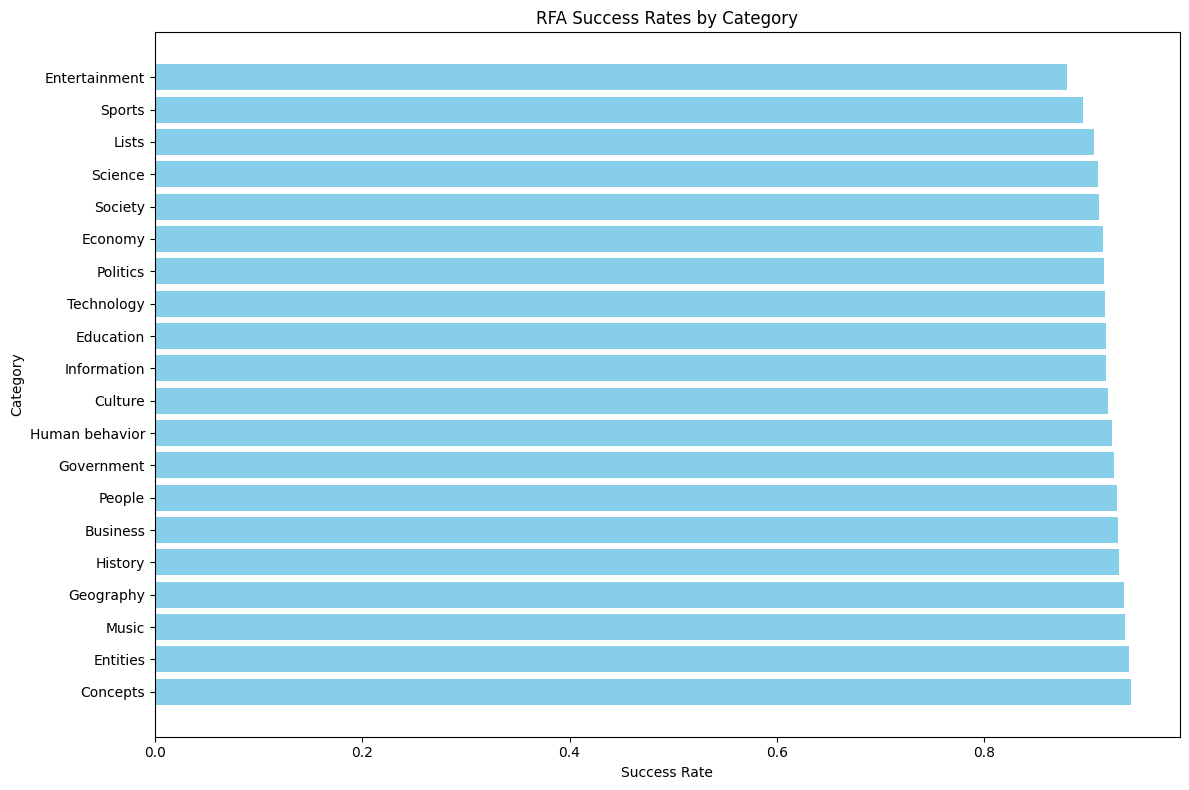

In [ ]:

# Display chi-square test results
print(f"Chi-square test result: chi2 = {chi2}, p-value = {p_value}")
if p_value < 0.05:
    print("Statistically significant association between category and RfA success.")
else:
    print("No statistically significant association between category and RfA success.")

#
# Plotting success rates by category
success_data_sorted = success_data.sort_values(by='Success_Rate', ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(success_data_sorted.index, success_data_sorted['Success_Rate'], color='skyblue')
plt.xlabel('Success Rate')
plt.ylabel('Category')
plt.title('RFA Success Rates by Category')
plt.tight_layout()
plt.show()


# Code

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Function to load and concatenate CSV files from a specific directory
def load_data(file_pattern):
    all_files = glob.glob(file_pattern)
    df_list = []
    for filename in all_files:
        try:
            df = pd.read_csv(filename)
            if 'total_score' not in df.columns:
                print(f"Skipping file {filename} as it lacks the 'total_score' column.")
                continue
            df_list.append(df)
        except pd.errors.ParserError:
            print(f"Skipping file {filename} due to parsing error.")
    if not df_list:
        raise ValueError("No valid files to load. Check your file pattern or content.")
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

# Function to plot frequency by score range
def plot_score_frequency(data, score_column='total_score', range_size=None):
    # Ensure the score column is numeric, handling non-numeric values
    data[score_column] = pd.to_numeric(data[score_column], errors='coerce')
    data = data.dropna(subset=[score_column])  # Drop rows with NaN scores

    # Calculate dynamic range size if not provided
    min_score = data[score_column].min()
    max_score = data[score_column].max()
    if range_size is None:
        range_size = (max_score - min_score) // 10  # Default to 10 bins
        range_size = max(1, int(range_size))  # Ensure a minimum range size of 1

    # Create bins based on the specified range size
    bins = range(int(min_score), int(max_score) + range_size, range_size)
    data = data.copy()
    data['Score Range'] = pd.cut(data[score_column], bins=bins)
    frequency = data['Score Range'].value_counts().sort_index()

    # Plotting
    plt.figure(figsize=(12, 6))
    bars = plt.bar(frequency.index.astype(str), frequency.values, color='skyblue', edgecolor='black')

    # Add annotations on top of the bars
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()),
                 ha='center', va='bottom', fontsize=9)

    plt.xlabel('Score Range', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Frequency of Scores by {range_size}-point Ranges', fontsize=14)

    # Limit the number of x-axis ticks
    x_ticks = range(0, len(frequency), max(1, len(frequency) // 10))  # Show ~10 ticks
    plt.xticks(ticks=x_ticks, labels=[str(frequency.index[i]) for i in x_ticks], rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Example usage
data = load_data('data/*.csv')

Skipping file data/new_admin_scores.csv as it lacks the 'total_score' column.
Skipping file data/admin_scores_ed3.csv due to parsing error.


In [ ]:

import json
import seaborn as sns


# List of categories to include in the plot
categories_to_include = [
    "Academic disciplines", "Business", "Communication", "Concepts", "Culture", "Economy", "Education", "Energy",
    "Engineering", "Entertainment", "Entities", "Food and drink", "Geography", "Government", "Health", "History",
    "Human behavior", "Humanities", "Information", "Internet", "Knowledge", "Language", "Law", "Life", "Lists", "Mass media",
    "Mathematics", "Military", "Nature", "People", "Philosophy", "Politics", "Religion", "Science", "Society", "Sports",
    "Technology", "Time", "Universe", "Other"
]

# Function to load and concatenate CSV files from a specific directory
def load_data(file_pattern):
    all_files = glob.glob(file_pattern)
    df_list = []
    for filename in all_files:
        try:
            df = pd.read_csv(filename)
            df_list.append(df)
        except pd.errors.ParserError:
            print(f"Skipping file {filename} due to parsing error.")
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

# Function to load user categories from JSON file and expand them
def load_user_categories(json_file):
    with open(json_file, 'r') as file:
        user_categories = json.load(file)
    
    # Convert the categories dictionary to a DataFrame with one row per username-category pair
    categories_expanded = []
    for username, categories in user_categories.items():
        for category in categories:
            categories_expanded.append({'username': username, 'Category': category})
    categories_df = pd.DataFrame(categories_expanded)
    return categories_df

# Function to plot score distribution in groups of categories based on user count
def plot_score_distribution_grouped(data, categories_df, selected_categories, score_column='total_score', min_count=20):
    # Convert score_column to numeric, coercing errors to NaN
    data[score_column] = pd.to_numeric(data[score_column], errors='coerce')
    data = data.dropna(subset=[score_column])

    # Merge categories with the main data on 'username'
    data = data.merge(categories_df, on='username')

    # Filter data to include only the selected categories
    data = data[data['Category'].isin(selected_categories)]

    # Calculate the number of people per category
    category_counts = data['Category'].value_counts()
    
    # Filter out categories with fewer than the minimum required count
    valid_categories = category_counts[category_counts >= min_count].index
    data = data[data['Category'].isin(valid_categories)]

    # Group categories by count ranges (e.g., categories with similar user counts)
    # Define group ranges based on quantiles or fixed intervals for simplicity
    count_bins = np.linspace(category_counts[valid_categories].min(), category_counts[valid_categories].max(), num=5)
    category_groups = {f'Group {i+1}': [] for i in range(len(count_bins)-1)}
    
    for category, count in category_counts[valid_categories].items():
        for i in range(len(count_bins) - 1):
            if count_bins[i] <= count < count_bins[i + 1]:
                category_groups[f'Group {i+1}'].append(category)
                break

    # Plot score distributions for each group of categories
    for i, (group_name, group_categories) in enumerate(category_groups.items()):
        if group_categories:  # Only plot if the group has categories
            min_count_in_group = min(category_counts[group_categories])
            max_count_in_group = max(category_counts[group_categories])
            plt.figure(figsize=(14, 8))
            sns.boxplot(x=score_column, y='Category', data=data[data['Category'].isin(group_categories)], orient='h')
            plt.xlabel('Score')
            plt.ylabel('Category')
            plt.title(f'{group_name} - Score Distribution for Categories with {min_count_in_group}-{max_count_in_group} People')
            plt.tight_layout()
            plt.show()

# Example usage
data = load_data('data/*.csv')  # Load CSV data
categories_df = load_user_categories('data/user_categories.json')  # Load and expand user categories



Skipping file data/admin_scores_ed3.csv due to parsing error.


# Admin scores distribution

We first plot the distribution of adminscores over the data set.

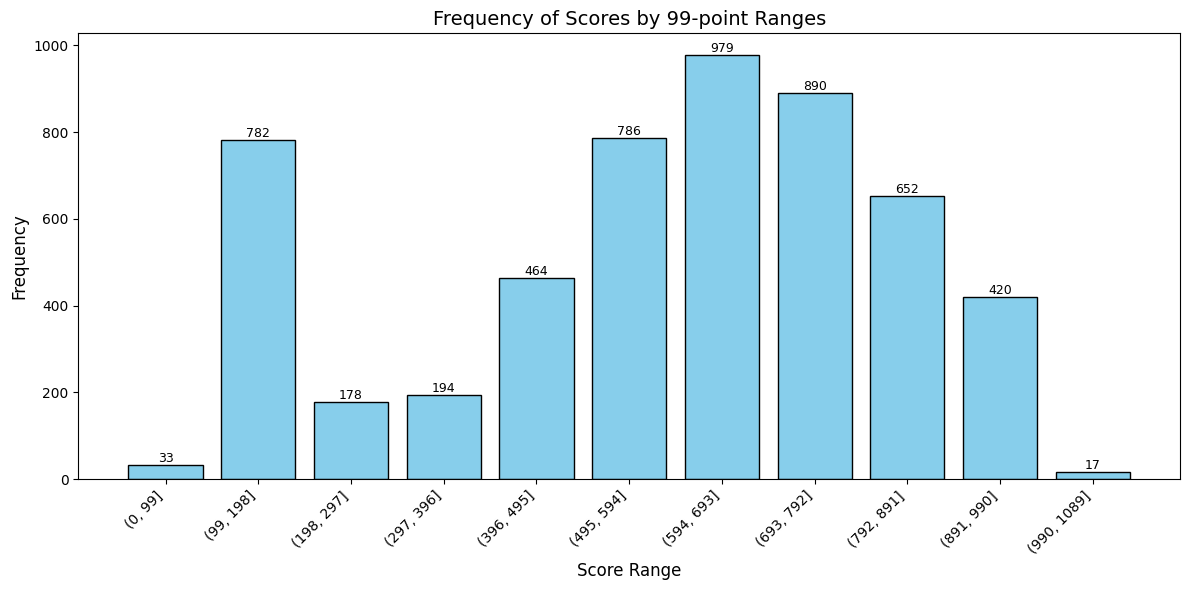

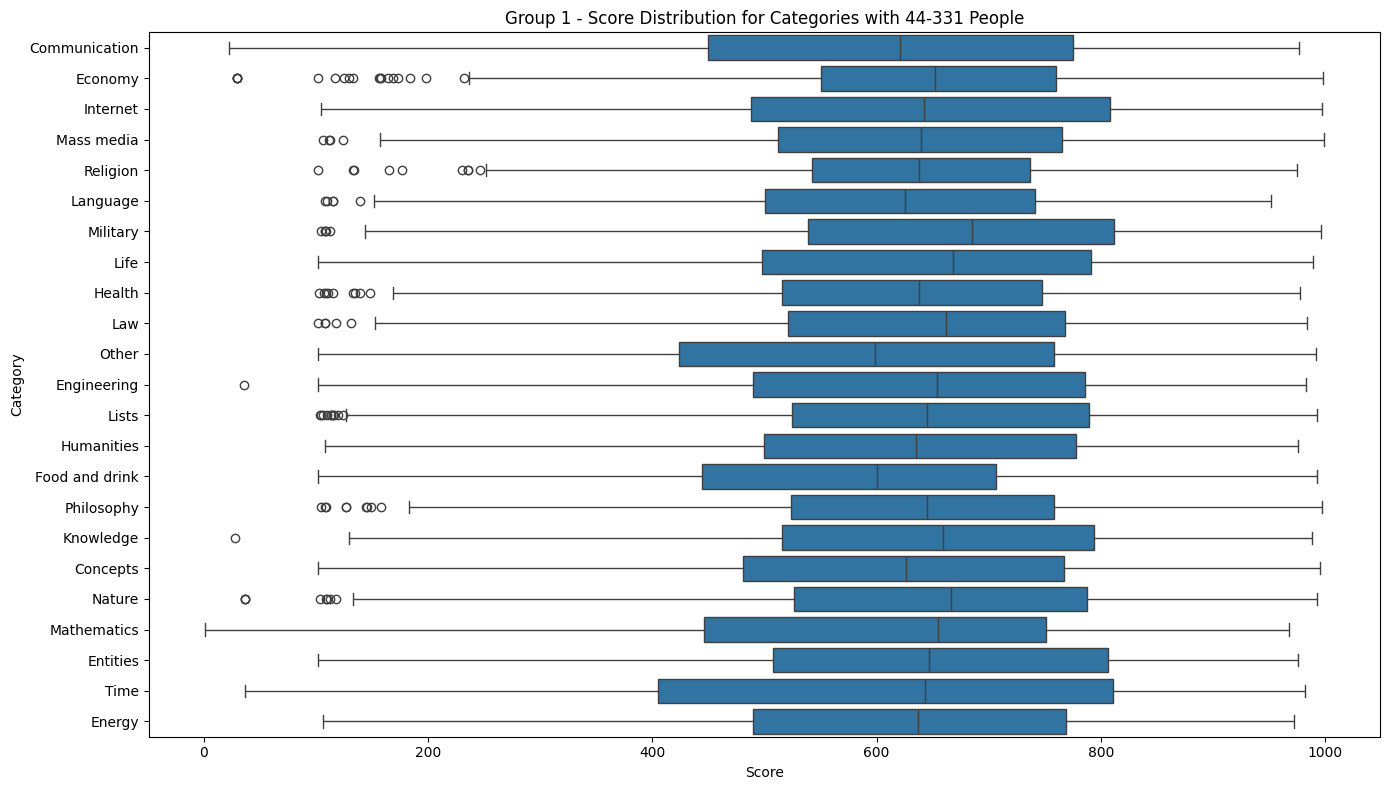

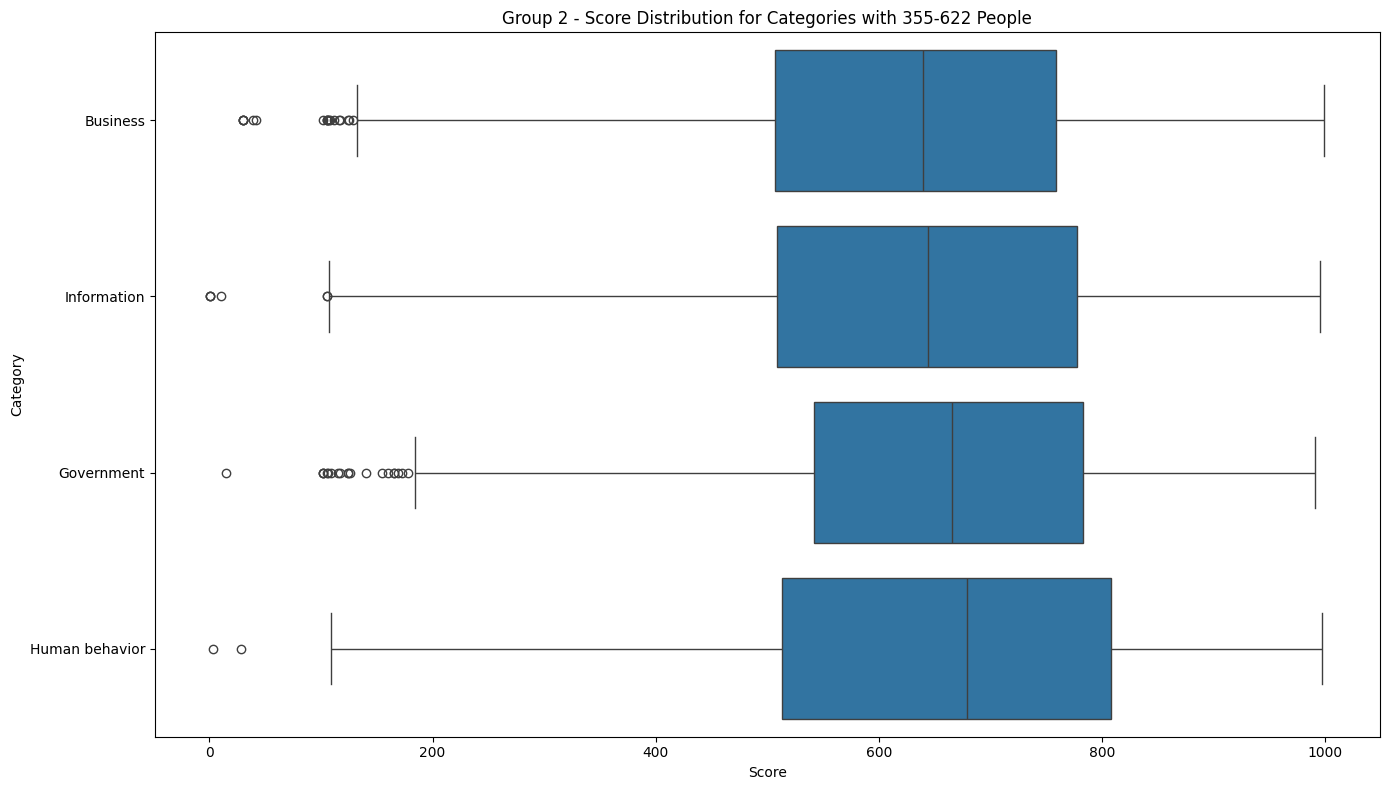

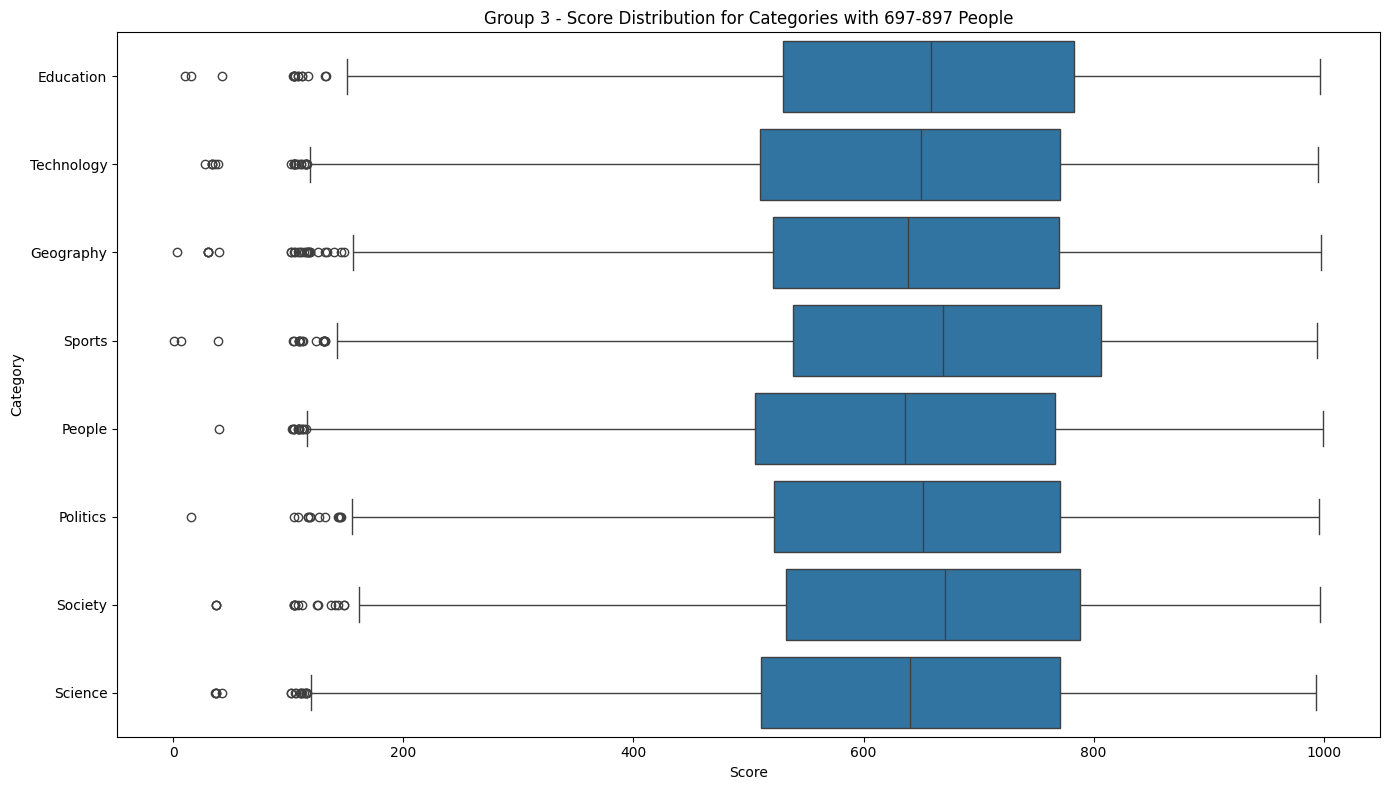

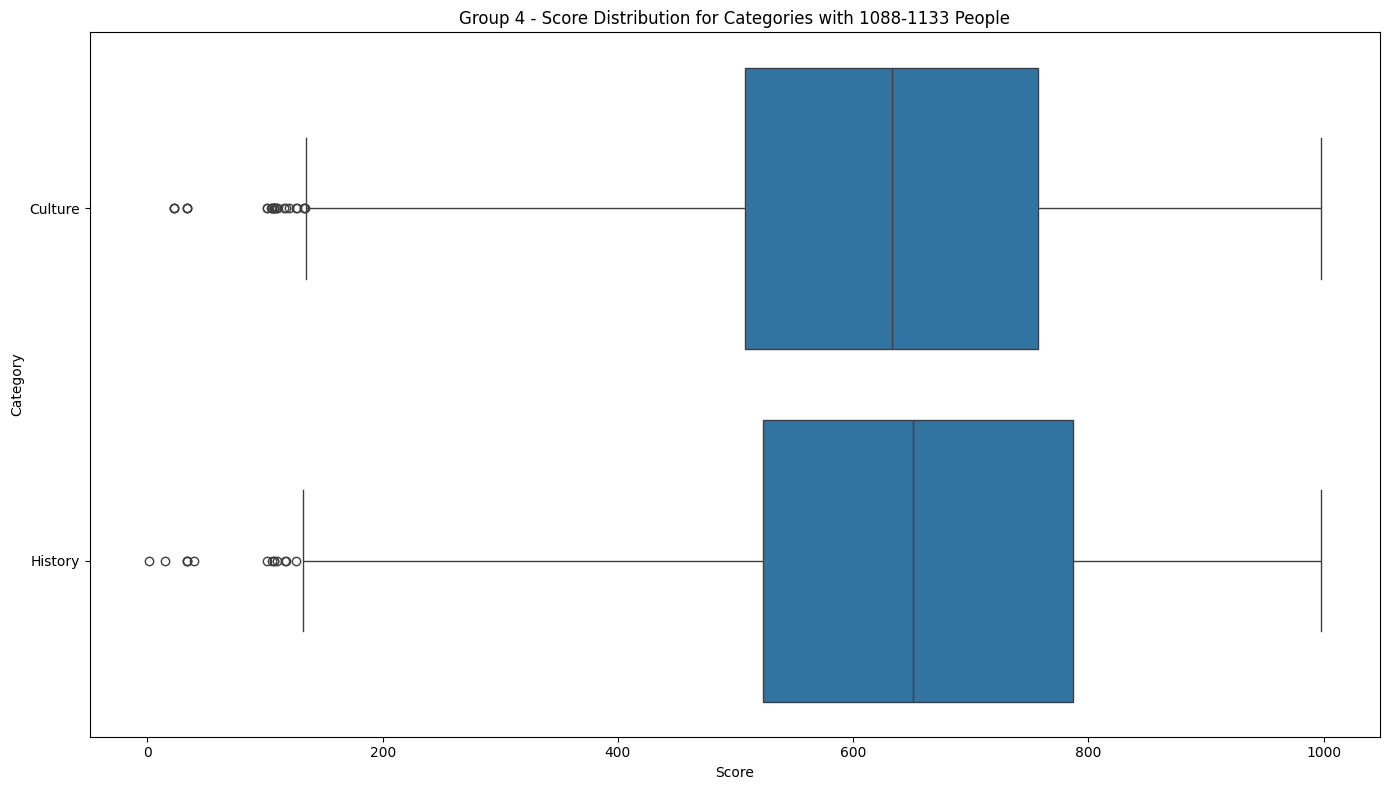

In [ ]:
import numpy as np 
plot_score_frequency(data, score_column='total_score')

# Plot score distribution grouped by user count similarity, with categories having at least 20 people
plot_score_distribution_grouped(data, categories_df, categories_to_include)


Let us notice that the boxplot for categories like, time, universe and others are not really significant since there are not enough users in these categories to fair results

## Approbation rates vs outcome

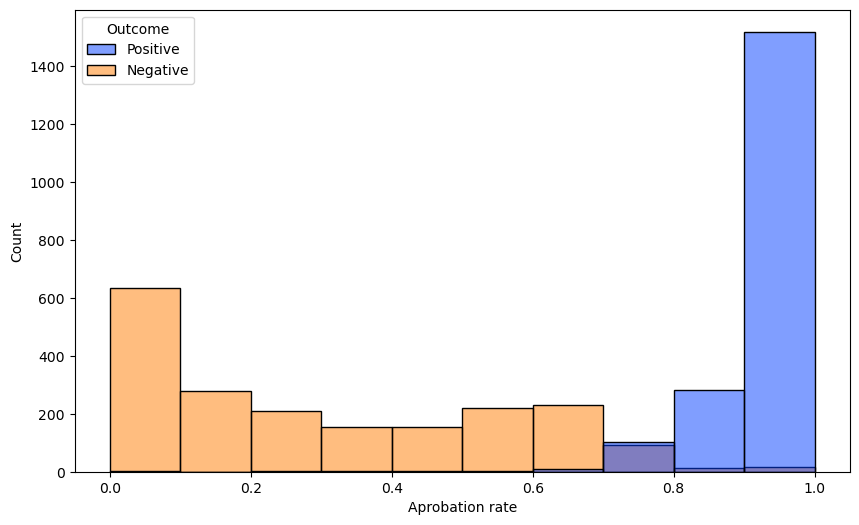

In [1]:
from src.scripts.GalPlots import *
plot_outcomes_approbation_rates("data/wiki-RfA.txt")

## Succes rate over years

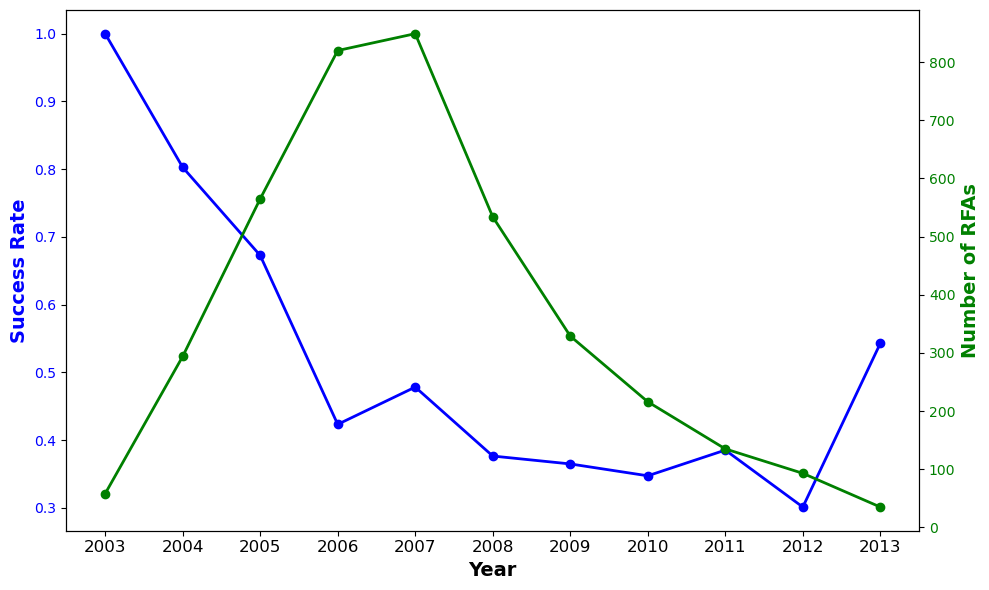

In [2]:
from src.scripts.GalPlots import *
plot_success_rates("data/wiki-RfA.txt")

## Admin score hist

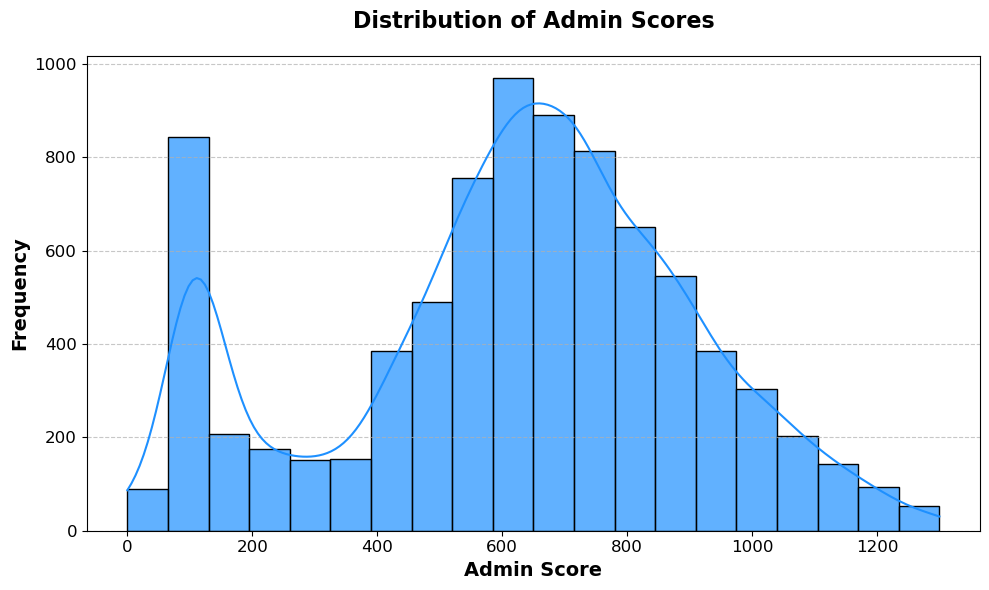

In [3]:
from src.scripts.GalPlots import *
plot_admin_scores_hist("data/scores.csv")